# Hadamard Phase Estimation

## Overview

- Type: Quantum subroutine for phase estimation.
- Estimated difficulty: Intermediate
- Preliminaries: Hadamard Test **(strongly recommended)**.
- Number of qubits: Size of $U$ and one auxiliary qubit.
- Number of operations: $O(1/\text{precision}^2)$ calls to the controlled-$U$.
- Maximum depth: $O(1/\text{precision}^2)$ for normal version, $O(1)$ using Hadamard test (see below).

Given a unitary $U$ with eigenvalue $e^{2\pi i \theta}$, the task of phase estimation is to determine the phase $\theta$ to precision $\epsilon$ with probability $1-\delta$. The simplest quantum algorithm for this tasks is *Hadamard phase estimation*. In this scheme, a Hadamard test circuit is used to encode the phase $\theta$ as an amplitude on an auxiliary qubit, which in turn relates to the probability $p$ of measuring $0$. By repeated measurements, this probability can be estimated, and the corresponding phase $\theta$ can be computed classically.

Hadamard phase estimation is not exactly the Hadamard test, but the two are closely related and can be considered identical in the case when the input state is an eigenstate. See "Relation to the Hadamard Test" for more details.

Hadamard Phase Estimation is iterative, meaning the same type of operation is repeated multiple times, and nonadaptive, meaning prior measurements do not affect subsequent choice of operations. Though simpler than other approaches, Hadamard phase estimation is also less accurate, scaling quadratically worse in $1/\epsilon$ than other common approaches. Kitaev phase estimation extends this protocol to remedy this deficiency with clever classical post processing. See the article on Kitaev phase estimation for further details.

## Description

**Put Hadamard test circuit here, but show measurement. Then emphasize that the main (bottom) register is inputted into the next iteration**

If you are familiar with the Hadamard test, you may like to skip to "Relation to Hadamard test," then return here as needed.

The basic circuit iteration is shown above. After each iteration, the auxiliary qubit is reset to $\vert0\rangle$ and the main register is maintained to the next iteration. Half of the iterations have the $S$ gate.

The iterations with no $S$ gate provide information about the real part of $e^{2\pi i \theta}$, while including $S$ provides information about the imaginary part. Together, these can be used to determine $\theta$ unambiguously.

### Eigenstate inputs

The principle of the method is best understood by considering eigenstate inputs. Let the input $\vert u\rangle$ be an eigenstate of $U$ with phase $\theta \in [0,1)$. As discussed in the Hadamard test article, the measurement probabilities without the $S$ gate are given by

$$
\Pr(0\mid \text{no}\;S) = \frac{1 + \cos 2\pi\theta}{2} \qquad \Pr(1\mid \text{no}\;S) = \frac{1 - \cos 2\pi\theta}{2}
$$

while, with the $S$ gate inserted, the probabilities are given by

$$
\Pr(0\mid S) = \frac{1 - \sin 2\pi\theta}{2} \qquad \Pr(1\mid S) = \frac{1 + \sin 2\pi\theta}{2}.
$$

By repeated measurement, we can estimate these probabilities, then derive estimates for $(\cos 2\pi \theta, \sin 2\pi\theta)$. This is a point on the unit circle which uniquely defines $\theta$. Both the $S$ and non-$S$ iterations are needed, because $\cos(2\pi\theta)$ and $\sin(2\pi\theta)$ are both needed to determine $\theta$ uniquely. 


### General inputs

What about the general case, where the input state $\vert\psi\rangle$ is a superposition

$$
\vert\psi\rangle = \sum_i c_i \vert u_i\rangle
$$

of eigenstates with phases $\theta_i$? As with other phase estimation algorithms, we should expect that, roughly speaking, one of the phases $\theta_i$ should be obtained with probability $\vert c_i\vert^2$, in line with the Born rule. This is mostly correct. It is slightly more accurate, but still incomplete, to say that any phases within $\pm\epsilon$ of the estimate will contribute to the total probability, since these are not distinguishable by the estimate. There is also some small failure probability. See "Analysis" for further details, though be advised there will be no proofs or qualifications of the claims made above. 

### Pseudocode

Inputs: 
1. A black box controlled-$U$
1. Input state $\vert\psi\rangle$ to main register
1. Precision $\epsilon$.

Procedure:
1. Set $m = O(1/\epsilon^2)$
1. Perform Hadamard phase estimation circuit of $2m$ iterations to obtain bitstrings $b_R, b_I \in \{0,1\}^m$. Here $b_R$ is the bitstring of measurements without the $S$ gate.
1. Find the zero counts $n_R$, $n_I$ for each bitstring, then obtain probability estimates $p_R = n_R/m$.
1. Compute estimates $c$ and $s$ for $\cos2\pi\theta$ and $\sin2\pi\theta$ as
$$
c = 2 p_R - 1,\qquad s = 1 - 2 p_I.
$$
1. Use these to obtain an estimate $\tilde{\theta}$ of $\theta$ to accuracy $O(\epsilon)$. 

Outputs: 
1. An estimate $\tilde{\theta_i}$ of an eigenphase $\theta_i$ of $U$, sampled approximately according to the Born rule, with all eigenstates with phases $\tilde{\theta_i} \pm \epsilon$ treated as indistinguishable. 
1. A approximate projection of the initial state onto eigenstates whose phase are within $\tilde{\theta_i}\pm\epsilon$.

## Relation to the Hadamard test

The Hadamard test and Hadamard phase estimation are nearly identical procedures, and easy to confuse. The only difference is whether the state of the main register is reset after each measurement of the auxiliary qubit. This distinction is irrelevant for eigenstate inputs, since such states are unaffected by the Hadamard test circuit. In this case, performing the reset can be beneficial by reducing maximum circuit depth. However, for input states that are superpositions of eigenstates (the general case), only Hadamard phase estimation will reliably estimate one of the phases in the superposition. This is because the Hadamard test estimates the expectation value $\langle U\rangle$ with respect to the input state, which on its own cannot provide information about the eigenphases.

## Qiskit Implementation

#### Relevant imports

In [4]:
import numpy as np
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit_aer.primitives import Sampler
from qiskit.circuit.library.standard_gates import SwapGate, TGate

#### Hadamard test circuit

The code below is borrowed from the Hadamard test compendium article. See that page for further details. This circuit fragment will be repeated over and over in Hadamard phase estimation, as described above.

In [5]:
def hadamard_circuit(U, add_s_gate=False, measure=True):
    """
    Args:
        U (Gate): Unitary gate in phase estimation problem
        add_s_gate (bool): Whether to at S gate to auxiliary register following controlled unitaries. 
            Equivalently, whether to perform C(U) (False) or C(i U) (True). 
        measure (bool): Whether to measure the auxiliary qubit (True) or not (False).
    Returns:
        QuantumCircuit that implements the Hadamard test
    """
    # Initialize registers and circuit
    aux = QuantumRegister(1, 'aux')
    main = QuantumRegister(U.num_qubits, 'q')
    circuit = QuantumCircuit(aux, main)
    
    # Construct controlled-U gate
    cU = U.control(1)
    
    # Add gates to circuit
    circuit.h(aux)
    circuit.append(cU, aux[:] + main[:])
    if add_s_gate:
        circuit.s(aux)
    circuit.h(aux)
    
    # Add measurement if option specified
    if measure:
        creg = ClassicalRegister(1, 'c')
        circuit.add_register(creg)
        circuit.measure(aux, creg)
    
    return circuit

#### Example: $U = Z$

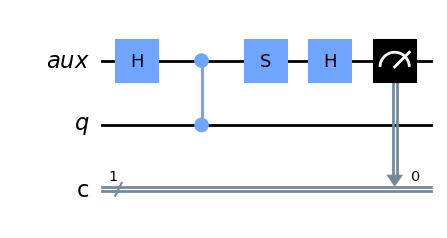

In [6]:
from qiskit.circuit.library.standard_gates import ZGate
hadamard_circuit(ZGate(), add_s_gate =True, measure = True).draw(output='mpl')

#### Contruct Hadamard phase estimation circuit


The following function creates the required circuit for Hadamard phase estimation, as discussed above.

In [9]:
# State of main register is not reset after each measurement. Allows for phase estimation over superpositions.
def coherent_Hadamard_circuit(U, Ncycles):
    """
    Args:
        U (Gate): Unitary gate for phase estimation protocol
        Ncycles: Number of measurements on auxiliary qubit. Equivalently, number of iterations of Hadamard test circuits. 
    Returns:
        QuantumCircuit that implements the normal version of Hadamard phase esitmation, where the state of the main register is not reset following measurements.
    """
    hadamard_circ = hadamard_circuit(U, add_s_gate = False, measure = True)
    
    
    # Initialize circuit with first iteration as initial fencepost
    circuit = hadamard_circuit(U, add_s_gate = False, measure = False)
    creg = ClassicalRegister(2*Ncycles, 'c')
    circuit.add_register(creg)
    circuit.measure(0, creg[0])
    circuit.reset(0)
    
    # Perform nonphased measurements
    for k in range(1, Ncycles):
        circuit = circuit.compose(hadamard_circ, qubits = None, clbits = k)
        circuit.reset(0)
        
    hadamard_circ = hadamard_circuit(U, add_s_gate = True, measure = True)
    
    # Perform phased measurements
    for k in range(0, Ncycles):
        circuit = circuit.compose(hadamard_circ, qubits = None, clbits = k + Ncycles)
        circuit.reset(0)
    
    return circuit

We demonstrate this construction for $U = \text{SWAP}$.

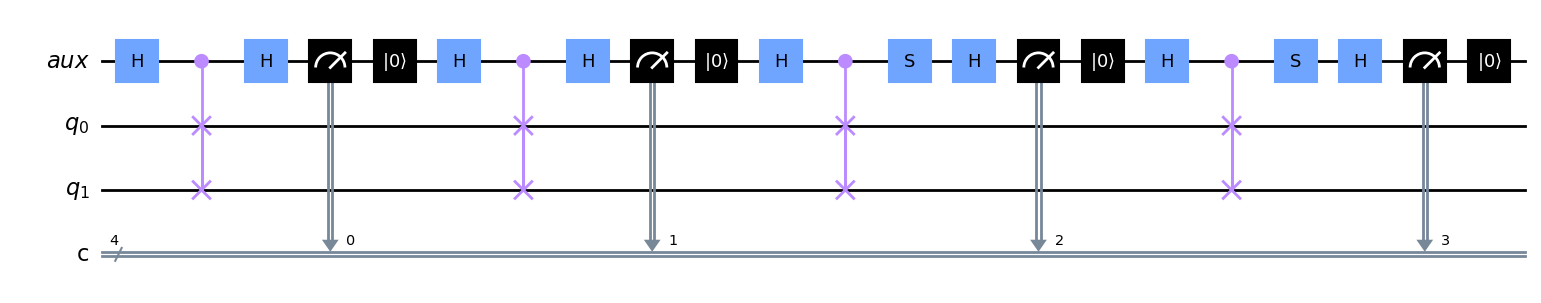

In [10]:
circuit = coherent_Hadamard_circuit(SwapGate(), 2)
circuit.draw(output = 'mpl')

Using `Ncycles = 2` is typically too short to get a good estimate, but we wanted to make the circuit easy to visualize. 

#### Hadamard phase estimation.

Below is a function to perform Hadamard phase estimation, either *coherent* (normal) or *incoherent* (full state reset) Hadamard phase estimation. We emphasize that the circuit for *incoherent* Hadamard phase estimation is simply the Hadamard test.

In [11]:
def Hadamard_phase_estimation(U, Uprep = None, precision = 2 * 10**-1, coherent = False, confidence_factor = 2):
    """
    Args:
        U (Gate): Unitary gate in phase estimation problem
        Uprep (Instruction): State preparation on main register starting from all |0> state (If None, no state prep added). 
        precision (float): Desired precision of phase estimate. 
        coherent (bool): Whether to keep state of principal register (True) 
            or reset to original state (False) after each measurement.
        confidence_factor (float): A parameter which scales the number of iterations proportionally. Should be set on the order of 1.
            Larger values increase confidence of answer being within set precision.
    Returns:
        An estimate for the phase of some eigenstate, sampled according to the initial state, with specified precision, and confidence related to confidence_factor.
    """

    Ncycles = int(confidence_factor//(precision**2))
    
    # Do single shot, coherent phase estimation if coherent = True
    if coherent:
        phase_estimation_circuit = coherent_Hadamard_circuit(U, Ncycles)
        # Perform state prep, if any
        if Uprep != None: phase_estimation_circuit.compose(Uprep, qubits = range(1,U.num_qubits + 1), front = True, inplace = True)
        # Run circuit
        job = Sampler().run(phase_estimation_circuit, shots = 1)
        result_dict = job.result().quasi_dists[0].binary_probabilities()
        measurements = list(job.result().quasi_dists[0].binary_probabilities())[0]
        
        # Split results into phased and unphased measurements
        phased_measurements = measurements[0:Ncycles]
        unphased_measurements = measurements[Ncycles:2*Ncycles]

        
        # Compute Hamming weight to get counts
        phased_counts = np.sum(list(map(int,phased_measurements)))
        unphased_counts = np.sum(list(map(int,unphased_measurements)))
        
        # Extract Pr(0)
        unphased_p0 = 1 - unphased_counts/Ncycles
        phased_p0 = 1 - phased_counts/Ncycles
    else:  
        # Otherwise, do incoherent phase estimation
        unphased_circuit = hadamard_circuit(U, add_s_gate = False, measure = True)
        phased_circuit = hadamard_circuit(U, add_s_gate = True, measure = True)
        # Do state prep, if any
        if Uprep != None:
            unphased_circuit = unphased_circuit.compose(Uprep, range(1,unphased_circuit.num_qubits),front = True)
            phased_circuit = phased_circuit.compose(Uprep, range(1,unphased_circuit.num_qubits), front = True)

        # Run circuits
        unphased_results = Sampler().run(unphased_circuit, shots = Ncycles).result().quasi_dists[0]
        phased_results = Sampler().run(phased_circuit, shots = Ncycles).result().quasi_dists[0]

        # Extract Pr(0)
        unphased_p0 = unphased_results.get(0, 0)
        phased_p0 = phased_results.get(0, 0)

    # Fully classical processing here on...
    
    # Get cosine and sine of phase
    costheta = 2*unphased_p0 - 1
    sintheta = 1- 2*phased_p0
    #Extract phase as final result
    theta = np.arctan2(sintheta, costheta)
    # Make branch correction to [0, 2 pi)
    if theta < 0: theta += 2*np.pi
    # Return number between 0,1
    theta = theta/(2*np.pi)
    return theta

As an example, we do a coherent Hadamard phase estimation using the SWAP gate. our initial state $\vert01\rangle$ is an equal superposition of a symmetric (+1) and antisymmetric (-1) eigenstate of SWAP. Therefore, we will measure phases of $0$ or $.5$, each with 50% probability.

In [24]:
# Prepare a superposition of symmetric.
prep_circuit = QuantumCircuit(2)
prep_circuit.x(0)

phase = Hadamard_phase_estimation(SwapGate(), Uprep = prep_circuit, precision = 10 **-1, coherent = True, confidence_factor = 2)
phase

0.016733314117554483

## Analysis 

### Measurements are identically distributed

It may seem strange that we treat each measurement as equivalent in the protocol, without respect to ordering, given that the state of the main register can change following each iteration. Surprisingly, each of the measurements is an *identical* binary random variable. In other words, the measurements behave as identical coin flips, where the probability of heads ($0$) is not necessarily $1/2$ but some unknown $p$. By running the circuit with $m$ measurements, we can sample this binary variable and estimate $p$ from the $0$ counts. 

The fact that the different measurements are identically distributed is simply because the measurements commute, as can be seen here.

**images/identical-measurements.jpg**

Because, $\vert\phi \rangle = \vert\chi\rangle$, the order can be changed without changing the circuit. Thus, the statistics for $M_1$ and $M_2$ must be exactly the same. 

### Interpreting the sample probability

Heuristically, it is useful to interpret our measuring $p$ as "uncovering the true value" $p_{\theta_i}$. The odds of getting this will be $\vert c_i\vert^2$ for input state $\sum_i c_i \vert u_i\rangle$. This *only holds* because we've carried through the input state to the next iteration.

The probability that $p$ does not correspond to one of the $p_i$ is very small as the number of trials $m$ increases, for the same reason that getting $80%$ heads for 1000 tosses of a fair coin is nearly impossible. The *Chernoff bound* says that the probability of the estimate being greater than $\epsilon$ away from the true probability decreases as $e^{-\epsilon^2 m}$. Thus, with $m \in O(1/\epsilon^2)$ we can achieve reasonable confidence that we have estimated one of the $p_{\theta_i}$. 

Once we have our estimate $p \approx p_{\theta_i}$, we proceed along similar lines to the eigenstate input case and use the equations above to estimate $\cos 2\pi\theta_i$. This gives us information about $\theta_i$.

### Number of operations

The estimate of the phase is obtained from sampling a binary probability distribution. It is a well known fact from probability and statistics that the sample mean, which gives our estimate for the probability, has an error (variance) which scales as 

$$
\epsilon \in O\left(m^{-1/2}\right)
$$

where $m$ is the number of samples. Thus, for a given $\epsilon$, $m \in O(1/\epsilon^2)$ samples are needed to achieve the desired precision. This is the source of the number of operations quoted in the Overview section.

## References and resources

- Kitaev, Shen, Vyalvi, ["Classical and Quantum Computation"](https://bookstore.ams.org/gsm-47#:~:text=This%20book%20is%20an%20introduction,of%20complexity%20of%20an%20algorithm.) pages 126-127
- Svore, Hastings, Freedman, ["Faster Phase Estimation"](https://arxiv.org/abs/1304.0741) (2013)
- Nielsen and Chuang, pg 243-244, Problem 5.3 (Note that they call this "Kitaev's algorithm," illustrating the nonstandard naming conventions.)